# MNIST CNN in TensorFlow

In [30]:
!pip install tensorflow tfds-nightly

     |████████████████████████████████| 4.9 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 65.3 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 89.4 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 4.7 MB/s  eta 0:00:01


  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=4735a93a12f22598d8ecb495d759362447b87b9aaa95e88beed6a710ee82cf3a
  Stored in directory: /Users/lorybuttazzoni/Library/Caches/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [258]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

In [162]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [163]:
tfds.as_dataframe(ds_train.take(4), ds_info)

2022-11-14 00:38:35.038070: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,4
1,,1
2,,0
3,,7


In [164]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/lorybuttazzoni/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
   

2022-11-14 00:38:42.266610: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


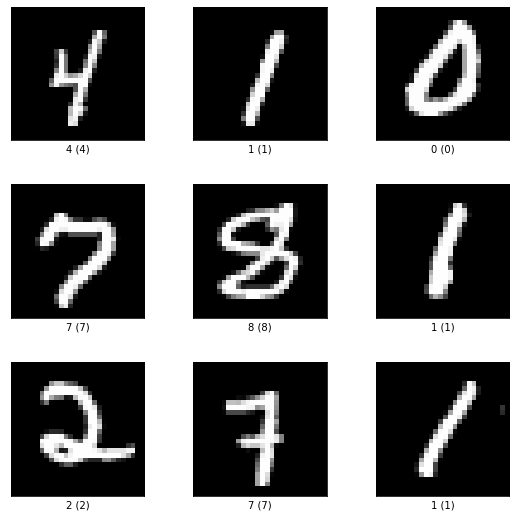

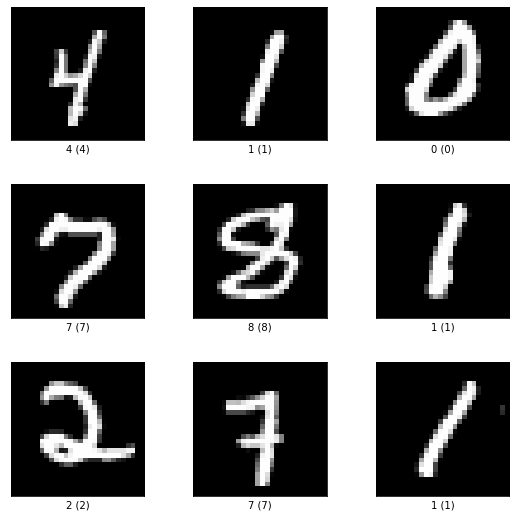

In [165]:
tfds.show_examples(ds_train, ds_info)

In [166]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)



ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(1000)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [167]:
ds_train.element_spec[0].shape

TensorShape([None, 28, 28, 1])

In [172]:
# Structure
model = models.Sequential()

model.add(layers.Conv2D(filters=10, kernel_size=5, activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(filters=20, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Dropout(rate=0.5))

model.add(layers.Flatten())

model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

# Compile
model.compile(
    optimizer = tf.keras.optimizers.SGD(
        learning_rate = 0.01,
        momentum = 0.5
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 12, 12, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 4, 4, 20)         0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 4, 4, 20)          0         
                                                                 
 flatten_17 (Flatten)        (None, 320)             

In [173]:
history = model.fit(
    ds_train,
    epochs = 6,
    validation_data = ds_test
)

Epoch 1/6
938/938 [==============================] - 13s 13ms/step - loss: 0.8484 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.1873 - val_sparse_categorical_accuracy: 0.9444
Epoch 2/6
938/938 [==============================] - 11s 12ms/step - loss: 0.2643 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.1216 - val_sparse_categorical_accuracy: 0.9627
Epoch 3/6
938/938 [==============================] - 14s 15ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9690
Epoch 4/6
938/938 [==============================] - 11s 12ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9456 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9741
Epoch 5/6
938/938 [==============================] - 12s 12ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.0728 - val_sparse_categorical_accuracy: 0.9777
Epoch 6/6
938/938 [==============================] - 11s 12ms/step - loss: 0.1465 - sparse_cate

#### Learned Weights (after training)

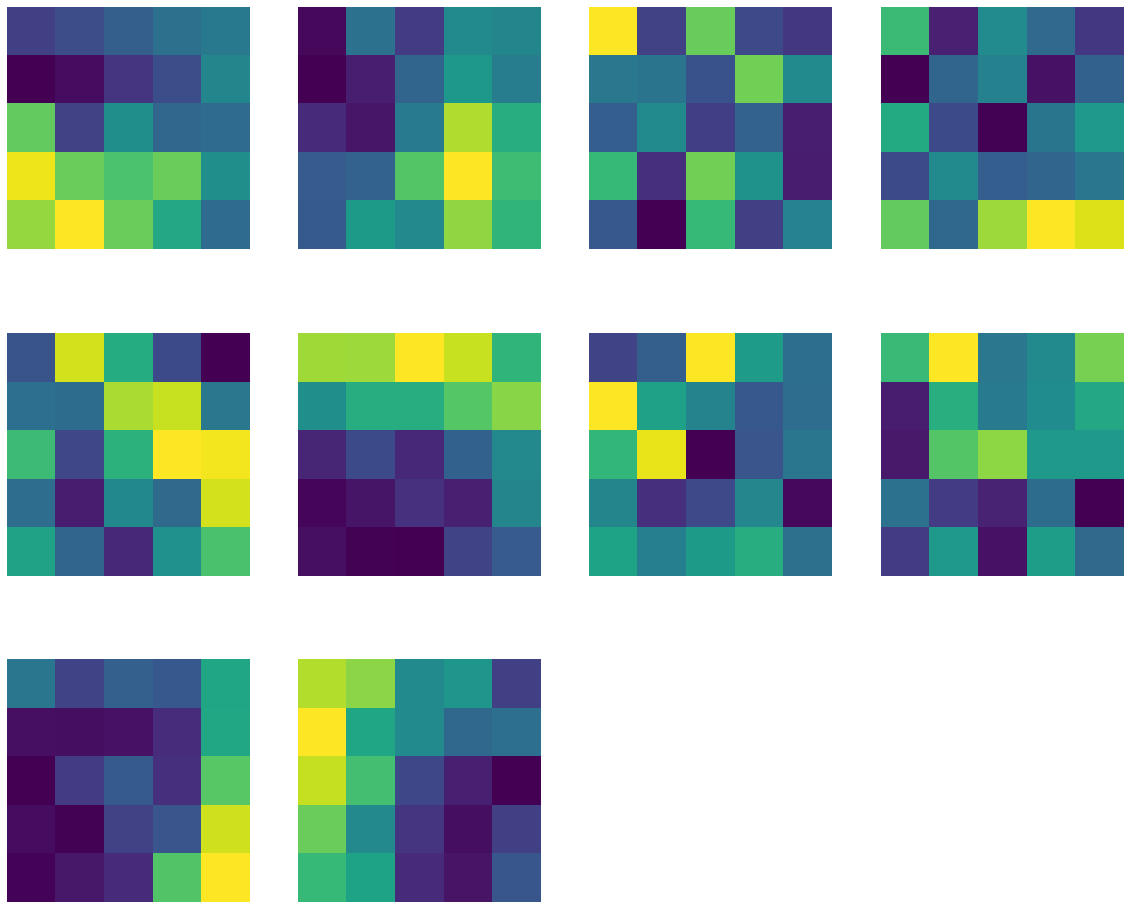

In [201]:
plt.figure(figsize=(20, 17))
for i in range(10):
    plt.subplot(3, 4, i+1) # we have 5x5 filters and total of 10 (see printed shapes)
    plt.imshow(model.trainable_weights[0][:, :, 0, i].numpy())
    plt.axis('off')
plt.show()

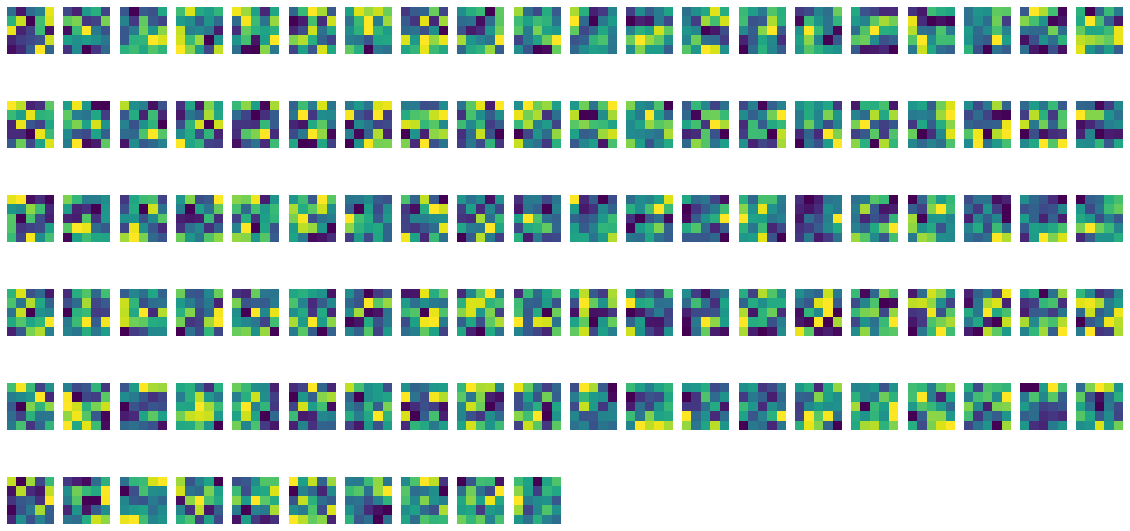

In [288]:
plt.figure(figsize=(20, 17))
for i in range(10):
    for j in range(20):
        plt.subplot(10, 20, i*10 + j + 1)
        plt.imshow(model.trainable_weights[2][:, :, i, j])
        plt.axis('off')
plt.show()

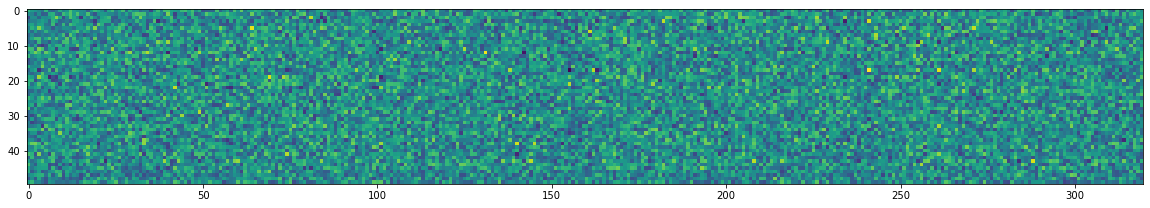

In [213]:
plt.figure(figsize=(20, 17))
plt.imshow(model.trainable_weights[4].numpy().T)

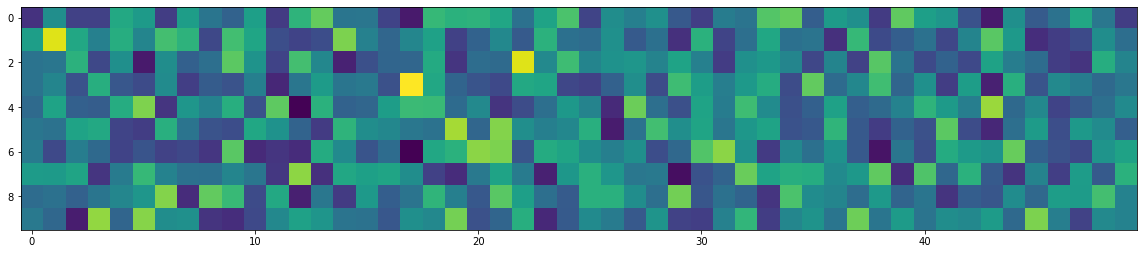

In [214]:
plt.figure(figsize=(20, 17))
plt.imshow(model.trainable_weights[6].numpy().T)

#### History (Callbacks)

In TensorFlow, the fitting (training) of the model returns a history object, which inherits from the callbacks class. We can create our own callback to log.

In [174]:
history

In [276]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [282]:
history.params

{'verbose': 1, 'epochs': 6, 'steps': 938}

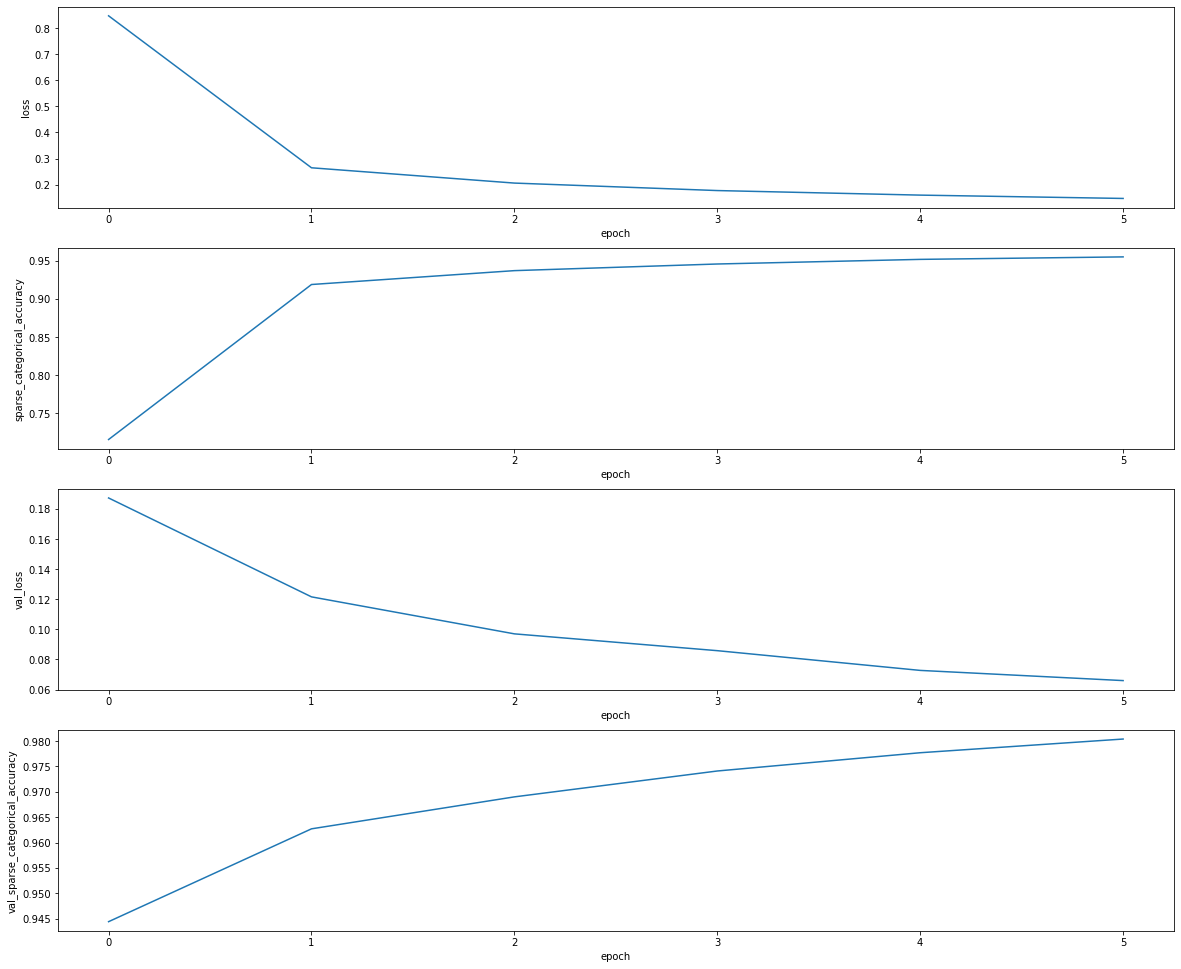

In [284]:
# This will plot what was printed to the console during the training.
plt.figure(figsize=(20, 17))
for i in range(4):
    idx = list(history.history.keys())[i]
    plt.subplot(4, 1, i+1)
    plt.ylabel(idx)
    plt.xlabel('epoch')
    plt.plot(history.history[idx])
plt.show()

#### Make a Prediction

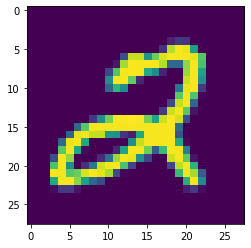

In [242]:
plt.imshow(next(iter(ds_test))[0][0, :, :, 0].numpy())

In [259]:
np.argmax(model.predict(ds_test)[0])

10/10 [==============================] - 0s 27ms/step


2